# Connect to google account

In [64]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [65]:
# 코렙 한글깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# 브라우저에서 바로 그려지도록
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

# Global Variables

In [66]:
import os
import numpy as np
import random
import torch

def reset_seeds(seed=500):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
  np.random.seed(seed)
  torch.manual_seed(seed) # cpu 연산 무작위 고정
  torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
  torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )

In [67]:
import easydict
args = easydict.EasyDict()

# path 정보
args.default_path = '/content/data/MyDrive/AI_study/1. Machine Learning/3. Supervised Learning/original data/'
args.train_csv = args.default_path+'train.csv'
args.test_csv = args.default_path+'test.csv'
args.default_submission_csv = args.default_path+'submission.csv'

args.submission_csv = args.default_path+'result/submission_0828_home_decisiontree.csv'
args.save_results = args.default_path+"result/model_results.json"

# 데이터 분석을 위한 변수들
args.random_state = 50 # 위의 셀에서 고정 시킴
args.results = []

# Load Tritanic

- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- gender:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [68]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

In [69]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

ori_train.shape, ori_test.shape

((916, 12), (393, 11))

In [70]:
pd.read_csv(args.default_submission_csv).shape

(393, 2)

In [71]:
ori_train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [72]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [73]:
ori_train['passengerid'].nunique(), ori_train.shape[0]

(916, 916)

In [74]:
ori_train.drop('passengerid', axis=1, inplace=True)
ori_train.head()

,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [75]:
ori_test.set_index(['passengerid'], inplace=True)
print(f'{ori_test.shape}')
ori_test.head()

(393, 10)


,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,
916,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q
917,2,"Pinsky, Mrs. (Rosa)",female,32.0,0,0,234604,13.0000,NaN,S
918,3,"McCarthy, Miss. Catherine Katie""""",female,NaN,0,0,383123,7.7500,NaN,Q
919,3,"Franklin, Mr. Charles (Charles Fardon)",male,NaN,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S
920,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S


# train_test_split

In [76]:
new_survived = pd.Categorical(ori_train["survived"])
new_survived = new_survived.rename_categories(["Died","Survived"])

new_survived.describe()

,counts,freqs
categories,,
Died,570,0.622271
Survived,346,0.377729


In [77]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [78]:
y = ori_train['survived']
X = ori_train.drop(['survived'], axis=1)

In [79]:
reset_seeds()
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, stratify=ori_train['survived'])

X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((641, 10), (275, 10), (641,), (275,))

# Base ModelV0

In [80]:
train = X_tr.copy()
test = X_te.copy()
ori_te = ori_test.copy()

train.shape, test.shape, ori_te.shape

((641, 10), (275, 10), (393, 10))

## Data Preprocessing

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 641 entries, 582 to 286
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    641 non-null    int64  
 1   name      641 non-null    object 
 2   gender    641 non-null    object 
 3   age       520 non-null    float64
 4   sibsp     641 non-null    int64  
 5   parch     641 non-null    int64  
 6   ticket    641 non-null    object 
 7   fare      641 non-null    float64
 8   cabin     153 non-null    object 
 9   embarked  640 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 55.1+ KB


drop columns

In [82]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (641, 10) / (275, 10)
after: (641, 7) / (275, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 641 entries, 582 to 286
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    641 non-null    int64  
 1   gender    641 non-null    object 
 2   age       520 non-null    float64
 3   sibsp     641 non-null    int64  
 4   parch     641 non-null    int64  
 5   fare      641 non-null    float64
 6   embarked  640 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 40.1+ KB


missing value

In [83]:
train.isnull().sum()

,0
pclass,0
gender,0
age,121
sibsp,0
parch,0
fare,0
embarked,1


In [84]:
test.isnull().sum()

,0
pclass,0
gender,0
age,59
sibsp,0
parch,0
fare,0
embarked,0


In [85]:
ori_te.isnull().sum()

,0
pclass,0
gender,0
age,83
sibsp,0
parch,0
fare,1
embarked,1


In [86]:
age_median = train['age'].median()
fare_median = train['fare'].median()
embarked_mode = train['embarked'].mode().values[0]

age_median, fare_median, embarked_mode

(27.0, 14.5, 'S')

In [87]:
train['age'].fillna(age_median, inplace=True)
test['age'].fillna(age_median, inplace=True)
ori_te['age'].fillna(age_median, inplace=True)

train['fare'].fillna(fare_median, inplace=True)
test['fare'].fillna(fare_median, inplace=True)
ori_te['fare'].fillna(fare_median, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

data encoding

In [88]:
from sklearn.preprocessing import OneHotEncoder

In [89]:
train.columns

Index(['pclass', 'gender', 'age', 'sibsp', 'parch', 'fare', 'embarked'], dtype='object')

In [90]:
print(test.columns)
print(ori_te.columns)

Index(['pclass', 'gender', 'age', 'sibsp', 'parch', 'fare', 'embarked'], dtype='object')
Index(['pclass', 'gender', 'age', 'sibsp', 'parch', 'fare', 'embarked'], dtype='object')


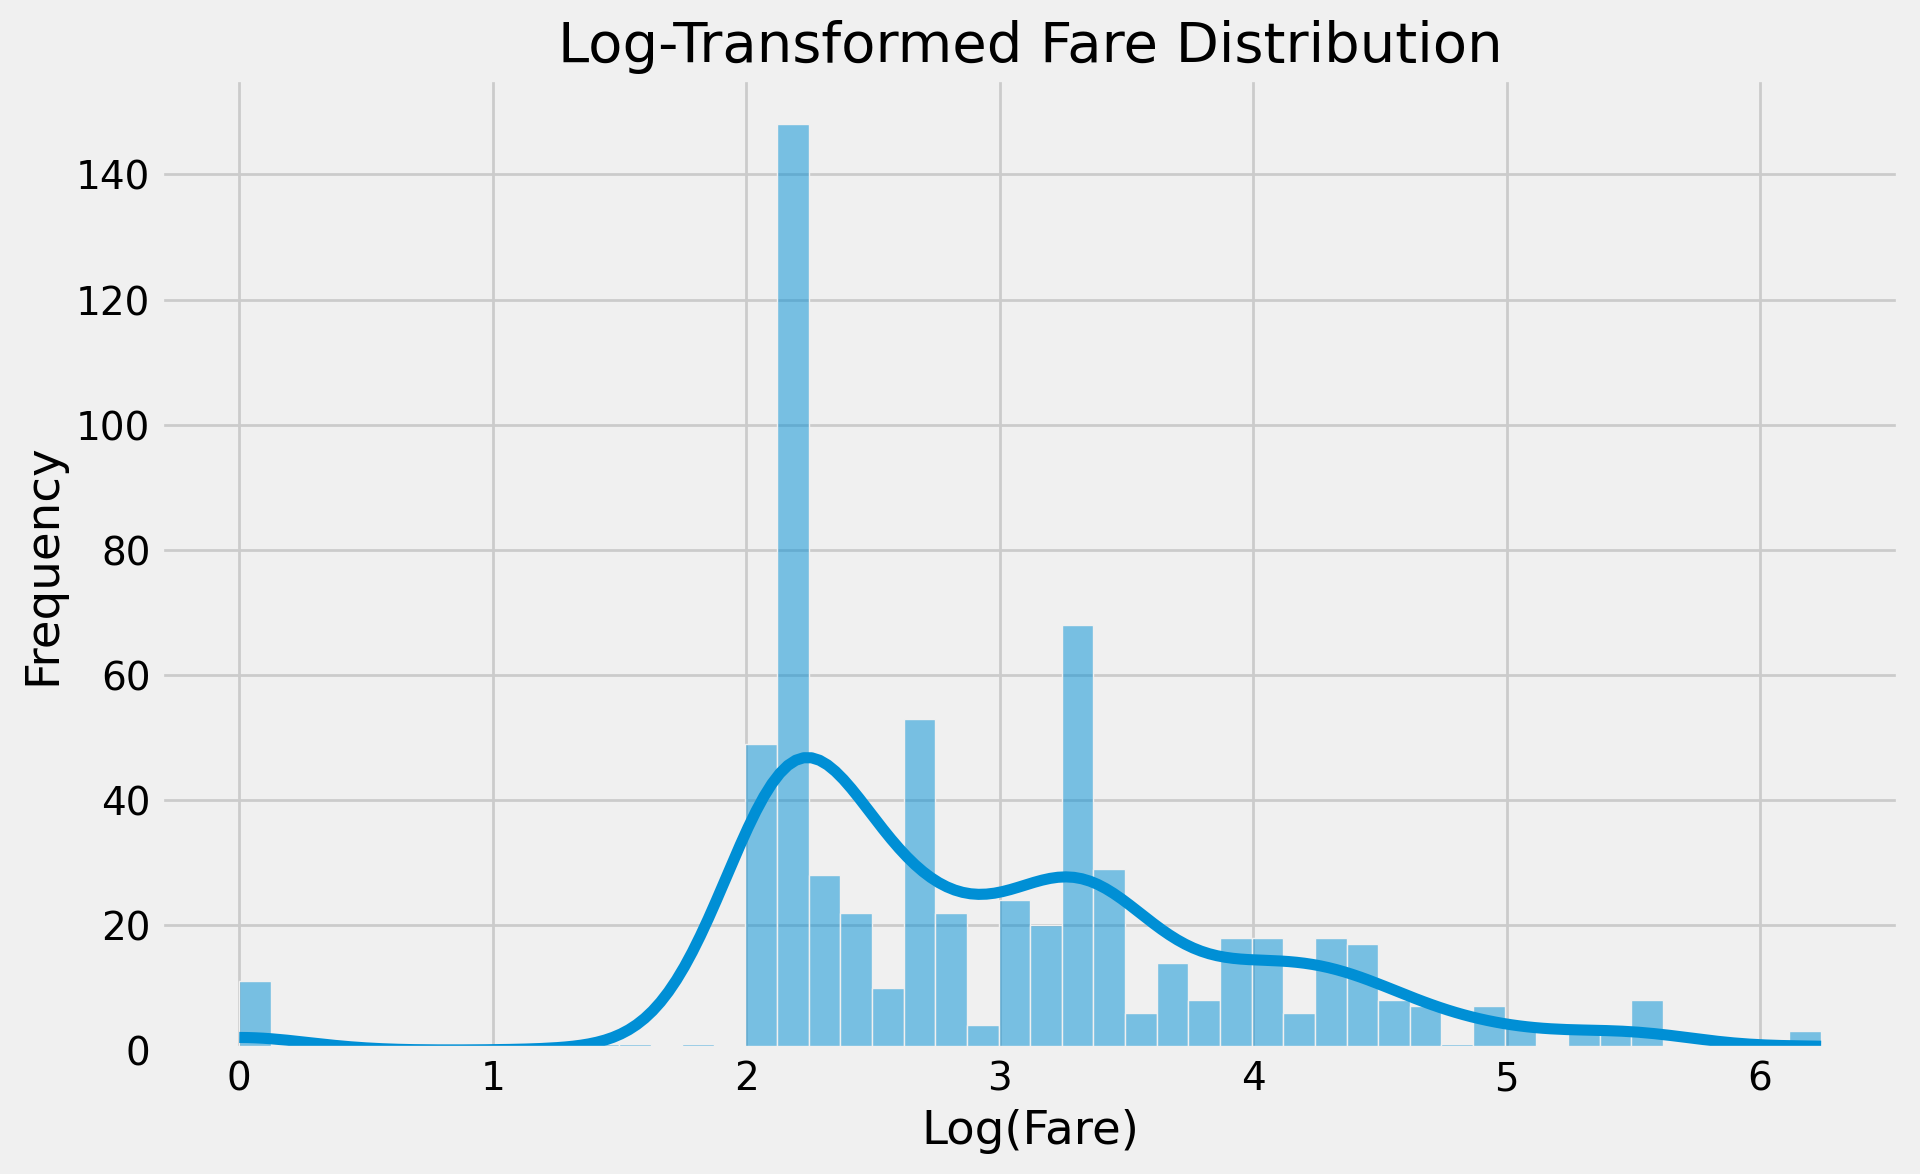

In [91]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 로그 변환 적용 (0 이상의 값에만 적용 가능)
train['fare_log'] = np.log1p(train['fare'])
test['fare_log'] = np.log1p(test['fare'])
ori_te['fare_log'] = np.log1p(ori_te['fare'])

# 기존 column 삭제
train.drop('fare', axis=1, inplace=True)
test.drop('fare', axis=1, inplace=True)
ori_te.drop('fare', axis=1, inplace=True)

# 로그 변환 후 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(train['fare_log'], bins=50, kde=True)
plt.title('Log-Transformed Fare Distribution')
plt.xlabel('Log(Fare)')
plt.ylabel('Frequency')
plt.show()


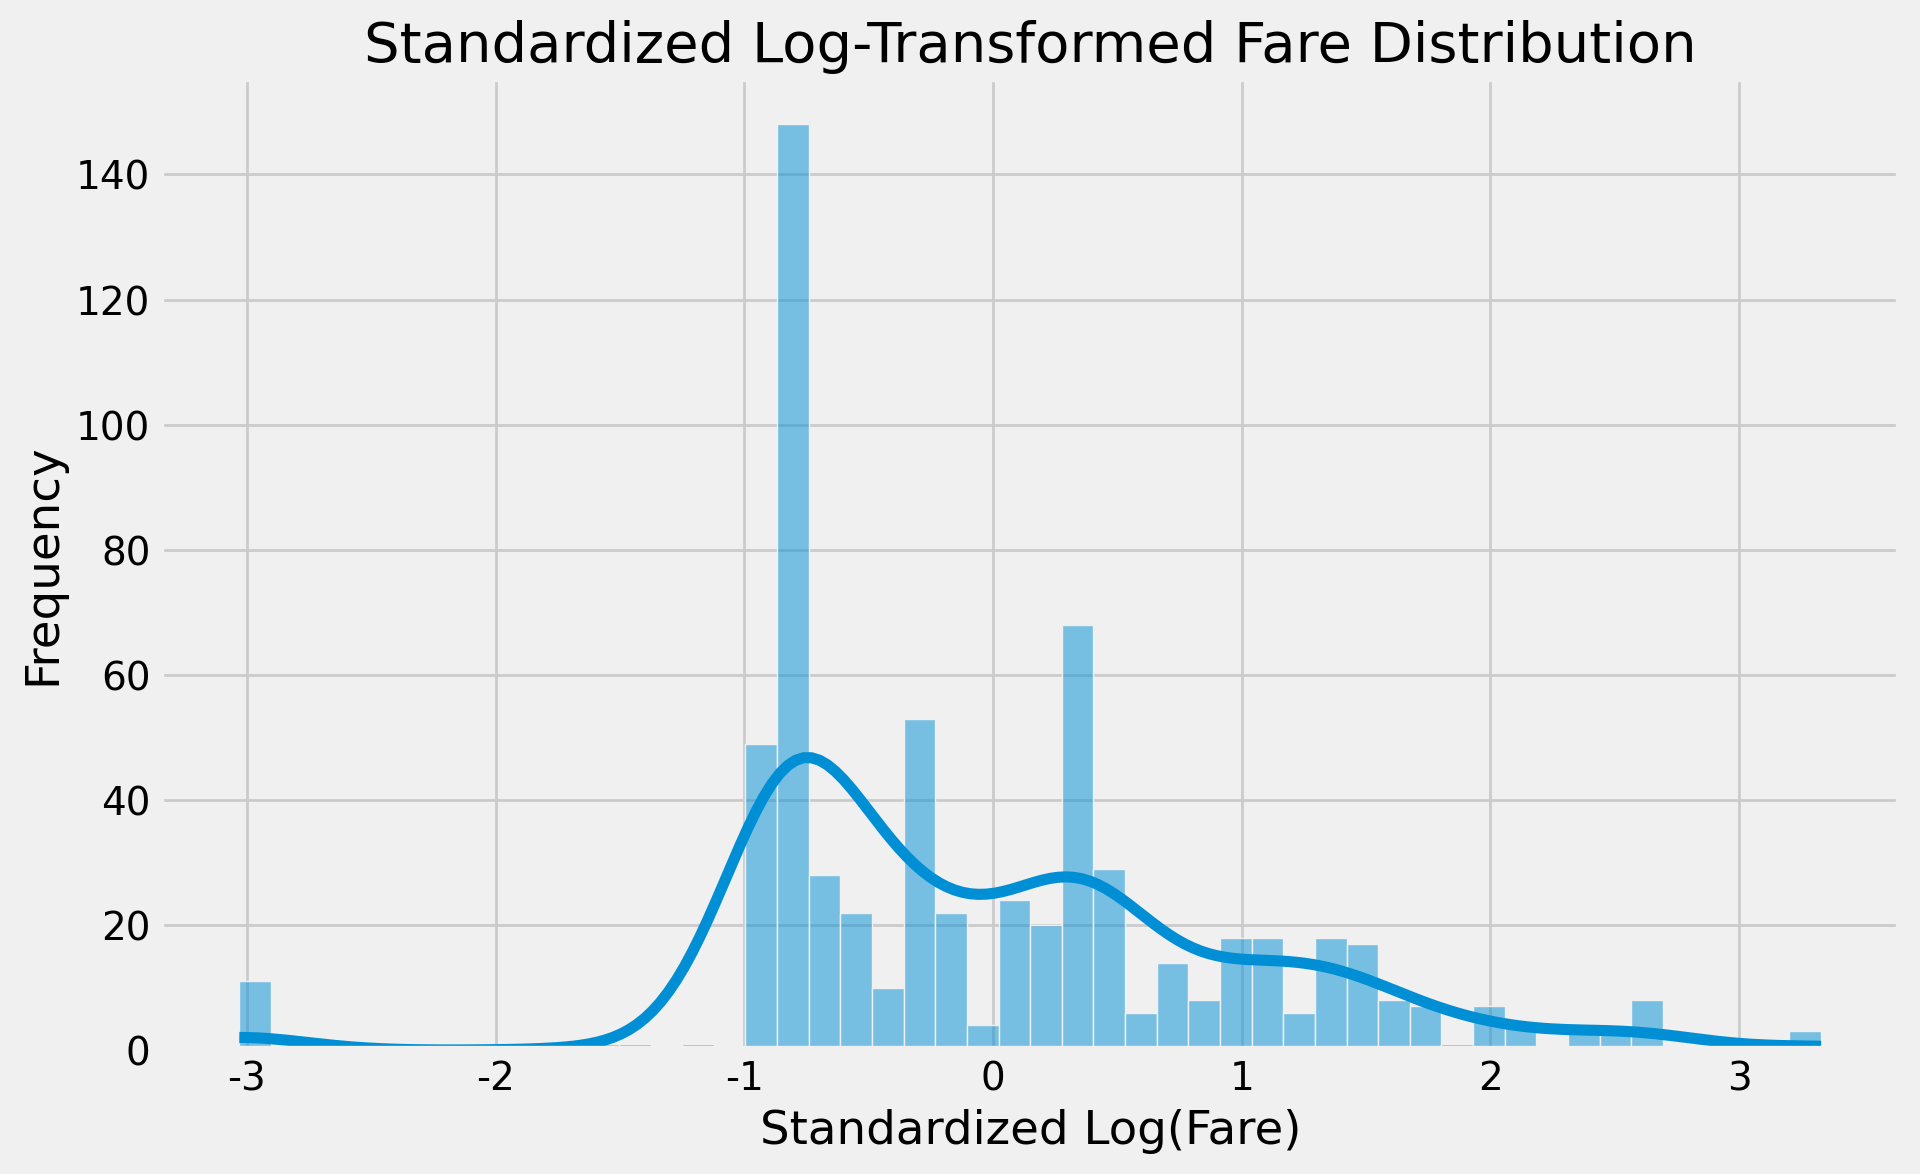

In [92]:
from sklearn.preprocessing import StandardScaler

# 로그 변환된 데이터를 표준화
scaler = StandardScaler()
train['fare_log_scaled'] = scaler.fit_transform(train[['fare_log']])
test['fare_log_scaled'] = scaler.transform(test[['fare_log']])
ori_te['fare_log_scaled'] = scaler.transform(ori_te[['fare_log']])

# 기존 columns 삭제
train.drop('fare_log', axis=1, inplace=True)
test.drop('fare_log', axis=1, inplace=True)
ori_te.drop('fare_log', axis=1, inplace=True)

# 표준화된 데이터의 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(train['fare_log_scaled'], bins=50, kde=True)
plt.title('Standardized Log-Transformed Fare Distribution')
plt.xlabel('Standardized Log(Fare)')
plt.ylabel('Frequency')
plt.show()


In [93]:
enc_cols = ['gender', 'embarked']
normal_cols = list(set(train.columns) - set(enc_cols))
normal_cols

['fare_log_scaled', 'parch', 'age', 'pclass', 'sibsp']

In [94]:
print(f'before: {train.shape} / {test.shape}')

enc = OneHotEncoder()
# train
tmp_tr = pd.DataFrame(
    enc.fit_transform(train[enc_cols]).toarray(),
    columns = enc.get_feature_names_out()
)
enc_tr = pd.concat(
    [train[normal_cols].reset_index(drop=True), tmp_tr.reset_index(drop=True)]
    , axis=1
)
# test
tmp_te = pd.DataFrame(
    enc.transform(test[enc_cols]).toarray(),
    columns = enc.get_feature_names_out()
)
enc_te = pd.concat(
    [test[normal_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
)
# ori_test
tmp_te = pd.DataFrame(
    enc.transform(ori_te[enc_cols]).toarray(),
    columns = enc.get_feature_names_out()
)
enc_ori_te = pd.concat(
    [ori_te[normal_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
)

print(f'after: {enc_tr.shape} / {enc_te.shape}')
enc_tr.head()

before: (641, 7) / (275, 7)
after: (641, 10) / (275, 10)


,fare_log_scaled,parch,age,pclass,sibsp,gender_female,gender_male,embarked_C,embarked_Q,embarked_S
0,-0.799821,0,32.0,3,0,0.0,1.0,0.0,0.0,1.0
1,-0.456534,0,21.0,2,0,0.0,1.0,0.0,0.0,1.0
2,-0.817093,0,27.0,3,0,0.0,1.0,0.0,0.0,1.0
3,-0.803160,0,19.0,3,0,0.0,1.0,0.0,0.0,1.0
4,-0.817093,0,74.0,3,0,0.0,1.0,0.0,0.0,1.0


## Training

In [96]:
enc_tr.isnull().sum().sum(), enc_te.isnull().sum().sum(), enc_ori_te.isnull().sum().sum()

(0, 0, 0)

In [97]:
enc_tr.shape, enc_te.shape, enc_ori_te.shape

((641, 10), (275, 10), (393, 10))

In [98]:
from sklearn.tree import DecisionTreeClassifier

In [99]:
modelV0 = DecisionTreeClassifier(random_state=args.random_state)
from sklearn.model_selection import cross_val_predict # 교차검증

y_tr = cross_val_predict(modelV0, enc_tr, y_tr, cv=5)
print(f'{enc_tr.shape} / {y_tr.shape}')
modelV0.fit(enc_tr, y_tr)

(641, 10) / (641,)


DecisionTreeClassifier(random_state=50)

## Evaluation

In [100]:
score_tr = modelV0.score(enc_tr, y_tr)
score_te = modelV0.score(enc_te, y_te)

score_tr, score_te

(0.9921996879875195, 0.7672727272727272)

In [101]:
from sklearn.metrics import roc_curve, auc

y_pred = modelV0.predict_proba(enc_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred)
print(y_pred.shape)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

(275,)
model: 0.7420152946468735


In [102]:
ori_te_pred = modelV0.predict_proba(enc_ori_te)[:,1]
ori_te_pred.shape

(393,)

In [103]:
modelV0.feature_importances_

array([0.23366835, 0.01828687, 0.18839496, 0.05220408, 0.03614902,
       0.        , 0.44155664, 0.01503645, 0.        , 0.01470363])

In [104]:
df_feature_importances = pd.DataFrame(modelV0.feature_importances_, enc_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

(10, 2)


,index,0
0,gender_male,0.441557
1,fare_log_scaled,0.233668
2,age,0.188395
3,pclass,0.052204
4,sibsp,0.036149
5,parch,0.018287
6,embarked_C,0.015036
7,embarked_S,0.014704
8,gender_female,0.000000
9,embarked_Q,0.000000


In [105]:
args.results.append(
    {
        'model': 'modelV4',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0217'
    }
)

args.results

[{'model': 'modelV4',
  'score_tr': 0.9921996879875195,
  'score_te': 0.7672727272727272,
  'auc_te': 0.7420152946468735,
  'ori_te_pred': array([1.        , 1.        , 1.        , 0.        , 1.        ,
         1.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 1.        , 1.        , 0.        ,
         1.        , 1.        , 0.        , 0.        , 0.        ,
         0.        , 1.        , 0.        , 1.        , 0.        ,
         0.        , 1.        , 0.        , 1.        , 0.        ,
         0.        , 1.        , 0.        , 0.        , 1.        ,
         0.        , 1.        , 1.        , 0.        , 1.        ,
         1.        , 0.        , 0.        , 0.        , 0.        ,
         1.        , 0.        , 1.

# Submission

In [106]:
df_results = pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)
df_results

,model,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt
0,modelV4,0.9922,0.767273,0.742015,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...",10,"[gender_male, fare_log_scaled, age, pclass, si...",0217


In [107]:
submission = pd.read_csv(args.default_submission_csv)
submission.head()

,passengerid,survived
0,916,0.5
1,917,0.5
2,918,0.5
3,919,0.5
4,920,0.5


In [108]:
submission['survived'] = df_results.loc[0, ['ori_te_pred']].values[0]

print(f'{submission.isnull().sum().sum()}')
submission.head(10)

0


,passengerid,survived
0,916,1.0
1,917,1.0
2,918,1.0
3,919,0.0
4,920,1.0
5,921,1.0
6,922,0.0
7,923,0.0
8,924,1.0
9,925,0.0


In [109]:
submission.to_csv(args.submission_csv, header=True, index=False)

# Save Results

In [110]:
args.save_results

'/content/data/MyDrive/AI_study/1. Machine Learning/3. Supervised Learning/original data/result/model_results.json'

In [111]:
df_results.columns

Index(['model', 'score_tr', 'score_te', 'auc_te', 'ori_te_pred',
       'len_features', 'feaute_importances', 'create_dt'],
      dtype='object')

In [112]:
df_results.drop(['ori_te_pred'], axis=1, inplace=True)

In [113]:
df_results.to_json(args.save_results, orient="records")

In [114]:
# 어떤 모델이 일을 잘했는지 확인 가능
df_results.head()

,model,score_tr,score_te,auc_te,len_features,feaute_importances,create_dt
0,modelV4,0.9922,0.767273,0.742015,10,"[gender_male, fare_log_scaled, age, pclass, si...",0217


In [115]:
import json

load_results = None
with open(args.save_results, 'r') as file:
    load_results = json.load(file)

load_results

[{'model': 'modelV4',
  'score_tr': 0.992199688,
  'score_te': 0.7672727273,
  'auc_te': 0.7420152946,
  'len_features': 10,
  'feaute_importances': ['gender_male',
   'fare_log_scaled',
   'age',
   'pclass',
   'sibsp',
   'parch',
   'embarked_C',
   'embarked_S',
   'gender_female',
   'embarked_Q'],
  'create_dt': '0217'}]

Confusion Matrix:
[[0.81871345 0.18128655]
 [0.34615385 0.65384615]]


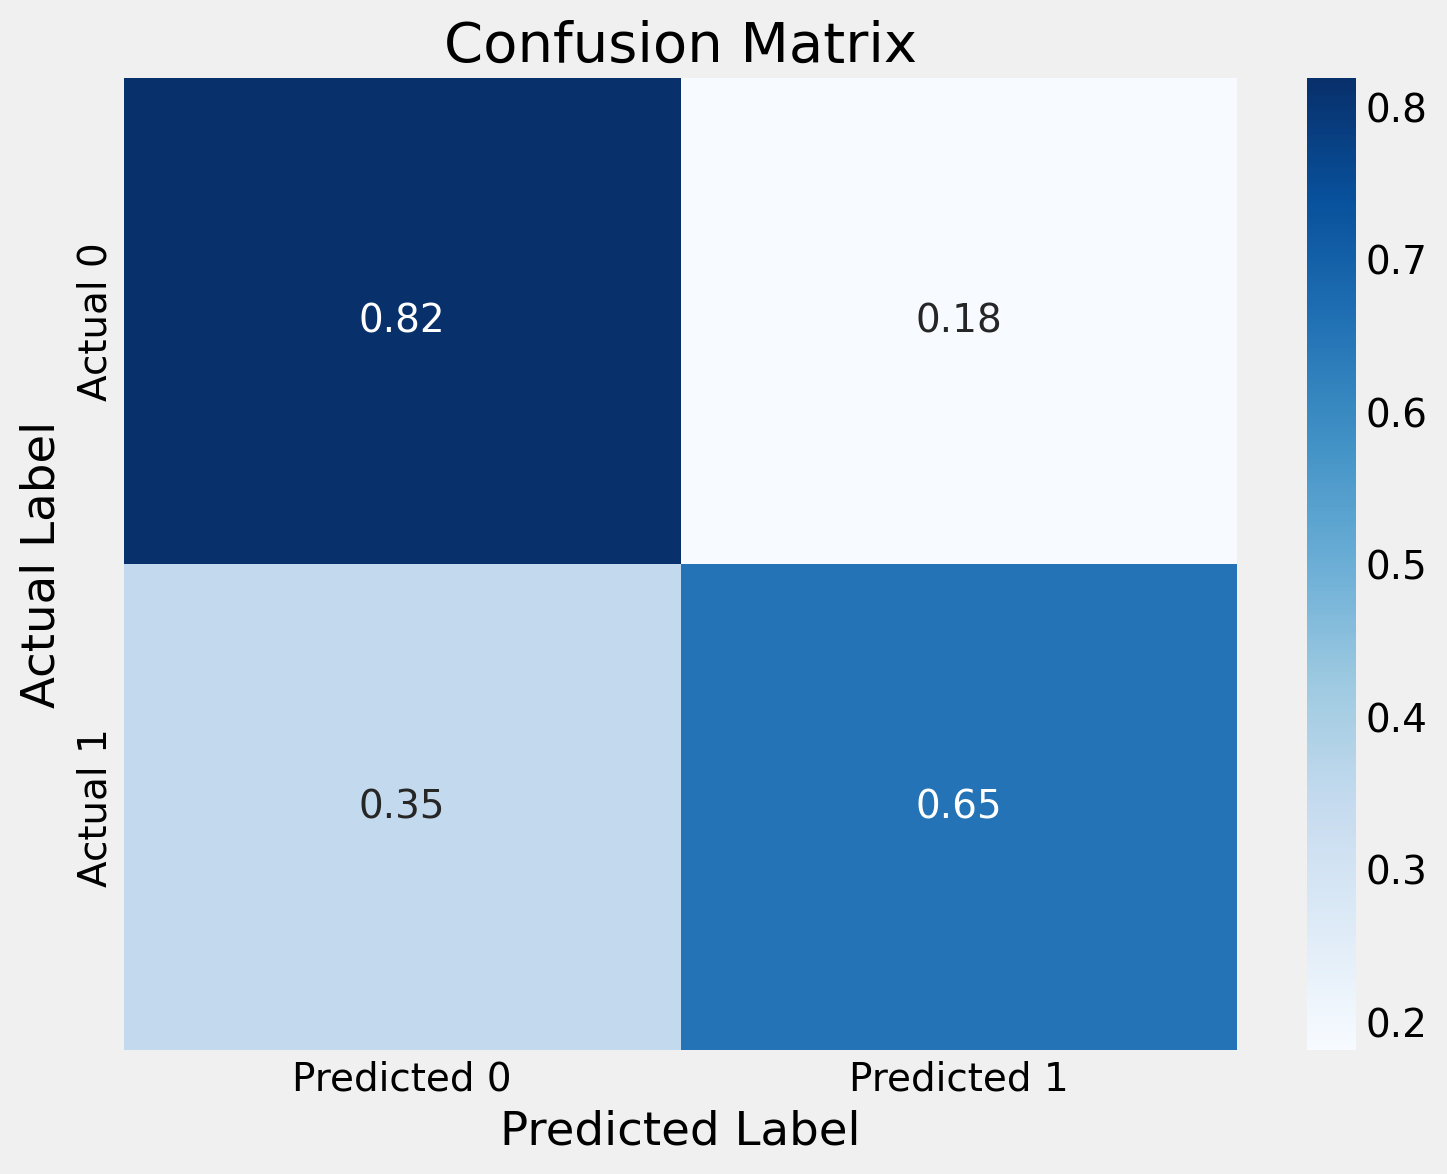

In [116]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 예시 데이터 (실제 데이터로 교체하세요)
actual = y_te
predict = y_pred  # 예측값

# 임계값 설정
threshold = 0.5
predict_binary = (predict >= threshold).astype(int)

# Confusion Matrix 계산
cm = confusion_matrix(actual, predict_binary, normalize="true")

# Confusion Matrix 출력
print("Confusion Matrix:")
print(cm)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()
